# miniSD - Fast Quarter-Sized Image Generation using Stable Diffusion
by John Robinson 04/14/2023 [Follow @johnrobinsn on Twitter](https://twitter.com/johnrobinsn)

<img src="https://www.storminthecastle.com/img/minisd_files/minisd.png"><br/>

[<img src="https://www.storminthecastle.com/img/github.svg">](https://github.com/johnrobinsn/ObjectDetectionNotebooks/blob/main/nbs/05_ssd_final.ipynb) [<img src="https://www.storminthecastle.com/img/colab.svg">](https://colab.research.google.com/github/johnrobinsn/ObjectDetectionNotebooks/blob/main/nbs/05_ssd_final.ipynb)

Whenever I need a bit of art for a blog article, I usually fire up my Stable Diffusion script, come up with a text prompt and generate a few samples and pick out a good sample or two.  But sometimes it can take quite a few generations to get something that I'm happy with.  So I'd like to be able to generate even more samples quickly, so that I can get to a good result without spending a ton of time.  

By default Stable Diffusion generates 512x512 pixel images, but for my blog articles I tend to use smaller 256x256 images which I just end up downsampling.  But can we get Stable Diffusion to directly generate the smaller 256x256 images faster?  The answer is yes on both counts, but out of the box the image quality is not as good as the 512x512 images, lacking in both texture and overall quality. But [Justin Pinkney](https://twitter.com/Buntworthy) found a [solution](https://twitter.com/Buntworthy/status/1580575210641960961?s=20) to this problem by finetuning Stable Diffusion's Unet on higher quality 256x256 images (random crops), he was able to get the 256x256 generated images to look almost as good as the 512x512 images and about **4x faster**.  

**4x Faster**

I packaged up [Justin's orignal checkpoint](https://huggingface.co/justinpinkney/miniSD) into a [diffuser's compatible model](https://huggingface.co/johnrobinsn/miniSD) for ease of use.

In the rest of this notebook, I demonstrate how stable diffusion works for 512x512 and 256x256 pixel output without Justin's miniSD checkpoint and then the improved 256x256 image output with his miniSD checkpoint.

## Install Dependencies and Import Modules

In [ ]:
def install_dependencies():
  !pip install -Uqq git+https://github.com/johnrobinsn/course22p2
  !pip install -Uqq torch
  !pip install -Uqq transformers
  !pip install -Uqq diffusers
  !pip install -Uqq accelerate

install_dependencies()

import torch
if torch.cuda.is_available():
  print("GPU found")
else:
  print("Change runtime type to GPU")
  
from miniai.activations import set_seed
from miniai.datasets import show_images
import matplotlib.pyplot as plt

## Instantiate the Normal Diffuser Pipeline

First to demonstrate the quality difference between the 512x512 and 256x256 pixel image generation, we'll use the default diffusers pipeline.

In [ ]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

### Generate 512x512 Pixel Images

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 24.6 s, sys: 1.35 s, total: 25.9 s
Wall time: 25 s


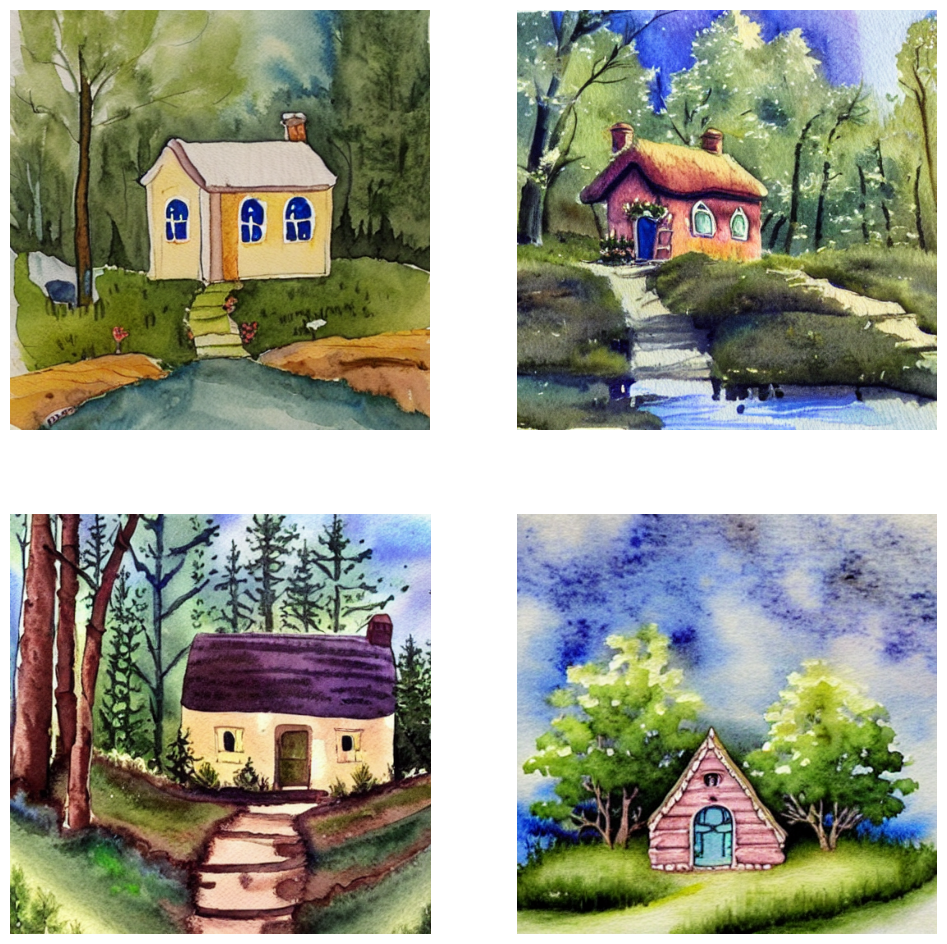

In [3]:
%%time
set_seed(42)
prompt = "a watercolor picture of a cute little cottage nestled in the woods"
images = pipe(prompt,num_images_per_prompt=4).images
show_images(images,figsize=(12,12))

### Generate Some Poor Quality 256x256 Pixel Images
As you can see below, the 256x256 pixel images generated using the default model weights are generally lacking in texture and quality as compared to the 512x512 images above.  But they are much faster to generate.  Next I'll show you how to use Justin's miniSD checkpoint to get both speed and the quality.

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 7.35 s, sys: 25.9 ms, total: 7.38 s
Wall time: 6.72 s


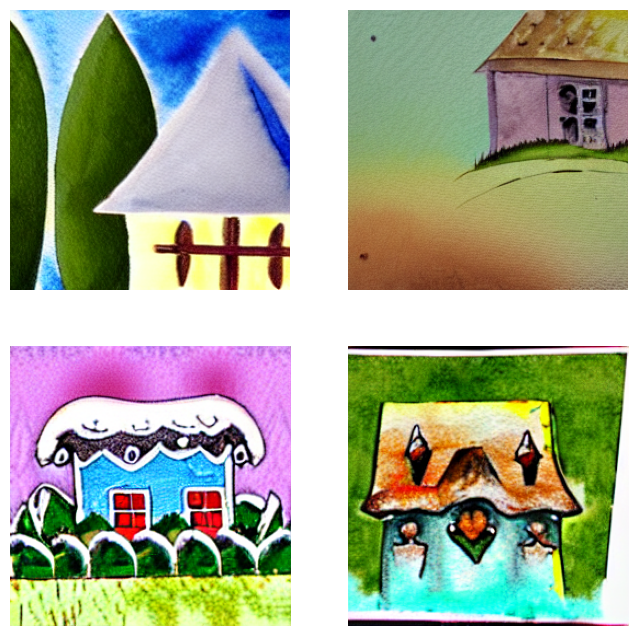

In [4]:
%%time
set_seed(42)
prompt = "a watercolor picture of a cute little cottage nestled in the woods"
images = pipe(prompt,width=256,height=256,num_images_per_prompt=4).images
show_images(images,figsize=(8,8))

### Fast 256x256 images using the miniSD checkpoint
Here we recreate the pipeline with Justin's miniSD checkpoint.  

_Note: I've made a diffusers compatible version of the checkpoint available on the HuggingFace model hub.  You can use the model name `johnrobinsn/miniSD` to load the model._

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("johnrobinsn/miniSD", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

### Generate Some Nice 256x256 Pixel Images
As you can see below the 256x256 pixel images generated using the miniSD checkpoint are much better quality and have much more texture than the 256x256 images generated using the default model weights.  And they are still much faster to generate than the 512x512 images.

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 7.32 s, sys: 25.4 ms, total: 7.34 s
Wall time: 6.7 s


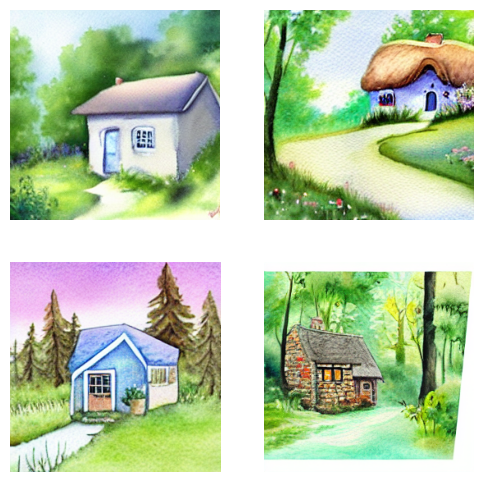

In [6]:
%%time
set_seed(42)
prompt = "a watercolor picture of a cute little cottage nestled in the woods"
images = pipe(prompt,width=256,height=256,num_images_per_prompt=4).images
show_images(images,figsize=(6,6),ncols=4,nrows=1)

### Try Another Prompt
Here we'll make twenty 256x256 images in the same time it takes to make four 512x512 images.

  0%|          | 0/50 [00:00<?, ?it/s]

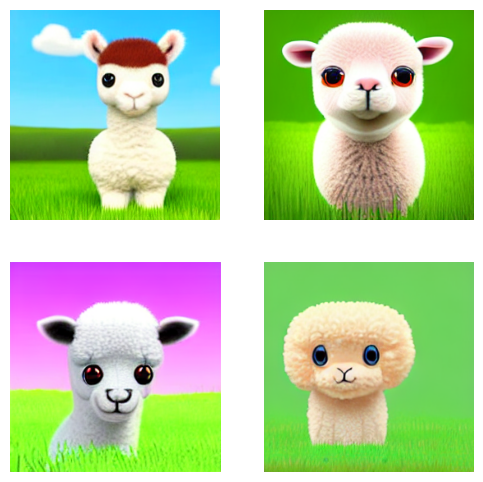

  0%|          | 0/50 [00:00<?, ?it/s]

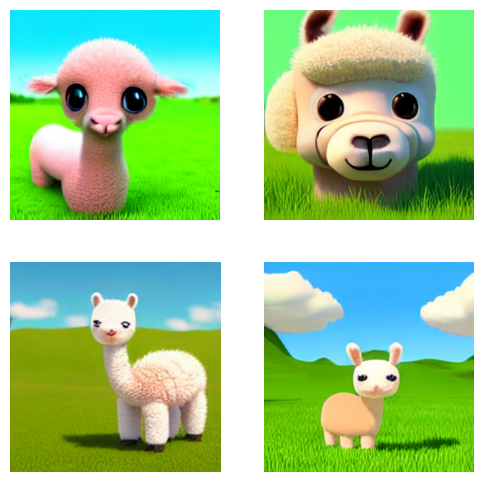

  0%|          | 0/50 [00:00<?, ?it/s]

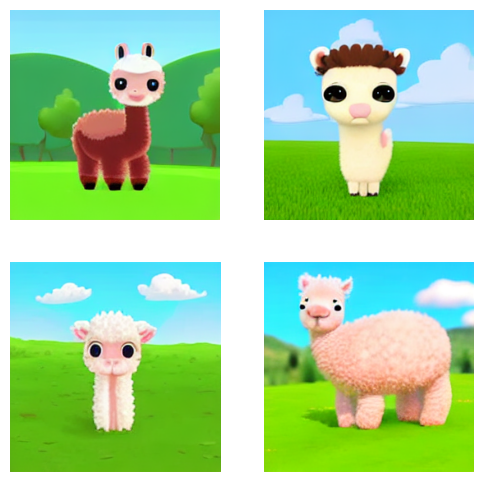

  0%|          | 0/50 [00:00<?, ?it/s]

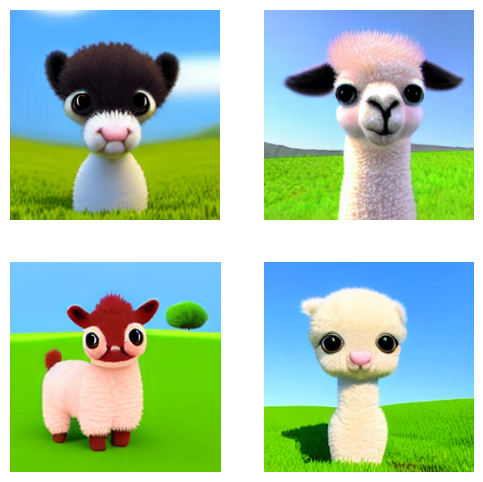

  0%|          | 0/50 [00:00<?, ?it/s]

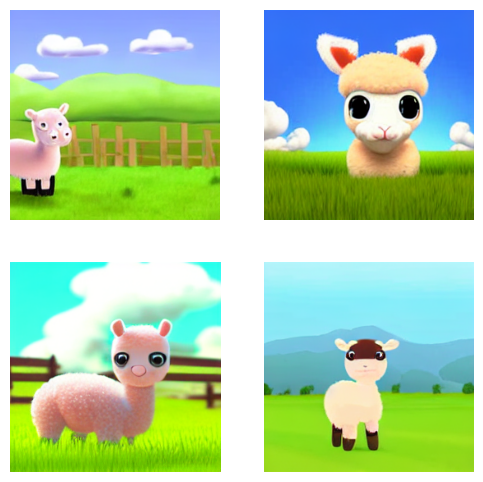

In [7]:
set_seed(42)
prompt = "a cute baby alpaca with big eyes in a pasture; 3d cartoon"
for _ in range(5):
  images = pipe(prompt,width=256,height=256,num_images_per_prompt=4).images
  show_images(images,figsize=(6,6),ncols=4,nrows=None)
  plt.show() # force rendering so we can see the generated images along the way

## Conclusion
Thanks to Justin for exploring this and sharing his results.  This was useful for my own work and I hope it is useful for you as well.

May your prompts be better than mine :-)

Please like and retweet my content on Twitter, [@johnrobinsn](https://twitter.com/johnrobinsn)